# My Approach

We can think of this problem in terms of vectors, their magnitudes, and circles. You sort the list of points in ascending order of their vector magnitudes and the magnitudes of these vectors correspond to the radius of a potential largest circle. This list is then iterated. On each iteration, we check if there exists a duplicate label seen (duplicate labels are tracked using a Set).


When we encounter a duplicate label, the previous point visited is the point corresponding to the largest radius we can draw.


# Edge Cases

There are two primary edge cases:

- The previous point (i.e. the $(i - 1)$-th point) prior to the first duplicate encountered (i.e the $i$-th point) shares the same magnitude and label. This is handled by making the $(i - 2)$-th point the valid point; bounds checks are handled as well.
- There does not exist a valid solution. For example, this can happen if a data set like `[([1, 2], 'A'), ([2, 1], 'A')]` is given.

For simplification of this problem, I assume that points laying "on" the radial shell to be contained within the largest valid circle.

# Generating Random Data

The following block is used to generate the random data for testing purposes. Low and high correspond to the start and end range of each randomized number and size corresponds to the random cardinality of the set of data points. The label space can be changed too, but then the color map function will need to be updated accordingly.

In [143]:
# Define the data type for the structured array
# '2i' means a pair of integers and 'U1' means single-character Unicode string.
data_type = [('coordinate', '2i'), ('label', 'U1')]

low = 1
high = 20
size = 20
label_space = ['A', 'B', 'C', 'D', 'E', 'F']

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Set, Tuple

def generate_random_data(low: int, high: int, size: int, label_space: List[str]) -> np.ndarray:
    """
    Generates a structured array of random points and corresponding labels. 
    """
    
    rng = np.random.default_rng()
    high = rng.integers(low + 1, high)
    size = rng.integers(low, high)

    low = -max(abs(low), abs(high))
    high = max(abs(low), abs(high))

    # Create an empty structured array
    random_data_points = np.empty(size, dtype=data_type)

    # Generate and assign random coordinates 
    random_x = rng.integers(low, high, size)
    random_y = rng.integers(low, high, size)
    random_data_points['coordinate'] = np.column_stack((random_x, random_y))

    # Generate and assign random labels
    random_data_points['label'] = np.random.choice(label_space, size=size)

    return random_data_points

# Not Currently in use.
def generate_fixed_data(coordinates: np.ndarray, labels: np.ndarray) -> np.ndarray:
    fixed_data_points = np.empty(shape=len(coordinates), dtype=data_type)

    fixed_data_points['coordinate'] = coordinates

    fixed_data_points['label'] = labels

    return fixed_data_points 

def radius_eqn(x: int, y: int, h: int = 0, k: int = 0) -> float:
    """
    Calculates the radius of a circle given a point (x, y) and a center (h, k).
    """
    return np.sqrt((x - h)**2 + (y - k)**2)

def color_map(label: str) -> str:
    color_dict = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'orange', 'E': 'purple', 'F': 'black'}
    return color_dict.get(label, 'gray') # grey as a default value. Won't happen, but good to have incase label space somehow changes.

def find_furthest_valid_point(data: np.ndarray) -> Tuple[np.ndarray, bool, np.ndarray]:
    """
    Finds the furthest valid point for which we can create a circle centerted at the origin h = 0, k = 0 with a radius that extends to include it.
    This radius is used in the circle equation r = sqrt[(x - h)^2 + (y - k)^2]
    """
    magnitudes = np.linalg.norm(data['coordinate'], axis=1)
    sorted_indices = np.argsort(magnitudes)
    sorted_data = data[sorted_indices]
    
    labels_seen: Set[str] = set()
    last_valid_point = None
    valid_solution = False

    for i, data_point in enumerate(sorted_data):
        current_magnitude = magnitudes[sorted_indices[i]]
        label = data_point['label']

        if label not in labels_seen:
            labels_seen.add(label)
            last_valid_point = data_point['coordinate']
            last_unique_label_magnitude = current_magnitude
            valid_solution = True
        else:
            # Duplicate label found. Edge case for when there is a duplicate label that isn't immediately preceded by the same label.
            # Different magnitudes, implies that the first duplicate label is not the same as the last valid point's label
            if last_unique_label_magnitude != current_magnitude:
                return last_valid_point, valid_solution, sorted_data
            elif i != 0 and sorted_data[i - 1]['label'] == label:
                # Implied same magnitude, same label case.
                # Return the point before the last valid point since the current point's label and magnitude are the same as the last valid point's label and magnitude. It also has a bounds check.
                return sorted_data[i - 2]['coordinate'], valid_solution, sorted_data
            else:
                # This would be the case for if we had something like [([1, 2], 'A'), ([2, 1], 'A')], which would mean there does not exist a valid solution.
                return None, False

    return last_valid_point, valid_solution, sorted_data

# Interactive Plot

The code below allows us to plot of all the random data points and create an interactive circle that snaps to the next radially outward point. The circle will be red if the circle is invalid, and green otherwise. There's also a button that will allow use to generate a new set of random data points to check valid circles against.



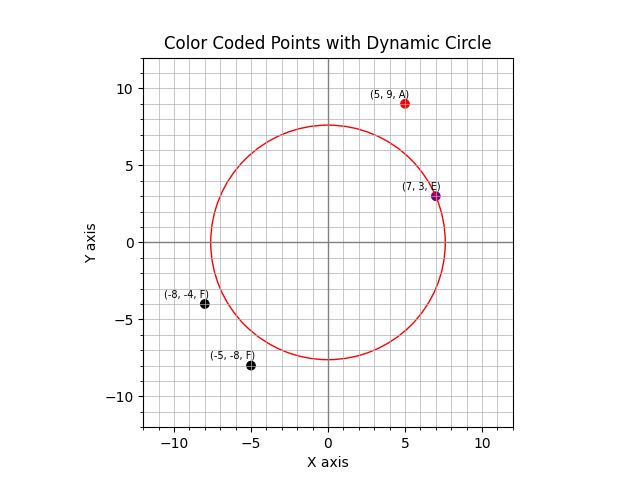

In [157]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, SelectionSlider, Button, VBox, Output
from IPython.display import display, clear_output

output_widget = Output()

def create_random_plot(ax):
    ax.clear()  # Clear existing plots before generating new data
    
    # Generate random data points
    random_data_points = generate_random_data(low, high, size, label_space)
    
    global furthest_point, valid_solution, sorted_data
    furthest_point, valid_solution, sorted_data = find_furthest_valid_point(random_data_points)

    with output_widget:
        clear_output(wait=True)
        print(f"Sorted Random Data Points: {sorted_data}")
   
    # Extract information from the generated data
    coordinates = [point['coordinate'] for point in sorted_data]
    labels = [point['label'] for point in sorted_data]
    colors = [color_map(label) for label in labels]
    x, y = zip(*coordinates)

    # Calculate magnitudes for setting grid limits
    magnitudes = np.linalg.norm(coordinates, axis=1)
    sorted_magnitudes = np.sort(magnitudes)
    
    # Plot points
    ax.scatter(x, y, c=colors)

    # Add labels to each point
    offset = 0.3
    for xi, yi, label in zip(x, y, labels):
        ax.text(xi + offset, yi + offset, f'({xi}, {yi}, {label})', fontsize=7, ha='right', va='bottom')

    # Set grid limits based on the furthest point
    grid_limit = int(max(magnitudes) + 2)
    ax.set_xlim(-grid_limit, grid_limit)
    ax.set_ylim(-grid_limit, grid_limit)
    ax.set_aspect('equal')

    # Add grid, ticks, and labels
    ax.grid(which='both', linestyle='-', linewidth=0.5)
    ax.minorticks_on()
    ax.axhline(0, color='grey', lw=1)
    ax.axvline(0, color='grey', lw=1)
    ax.set_title('Color Coded Points with Dynamic Circle')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')

    # Define update_circle as a closure with access to furthest_point.
    # This is to ensure that update_circle is "aware" of the newly generated data.
    def update_circle(radius):
        if hasattr(update_circle, 'circle') and update_circle.circle in ax.patches:
            update_circle.circle.remove()
        
        color = 'green' if furthest_point is not None and radius == np.linalg.norm(furthest_point) else 'red'
        update_circle.circle = plt.Circle((0, 0), radius, color=color, fill=False)
        ax.add_artist(update_circle.circle)
        fig.canvas.draw_idle()

    radius_slider.options = sorted_magnitudes
    radius_slider.value = radius_slider.options[0]  # Reset to the smallest magnitude to radiate outward from.

    # "syncs" interactive widget with new data s.t. it uses the newest version of update_circle. Old update_circle will get de-referenced for garbage collection.
    global interactive_plot
    interactive_plot = interactive(update_circle, radius=radius_slider)

    # Ensure the plot is updated
    plt.show()

def on_button_click(b):
    clear_output(wait=True) #clears existing output

    create_random_plot(ax) # New random data points

    display(VBox([button, interactive_plot])) # Re-Display Widgets


fig, ax = plt.subplots()

# Create button and event handler
button = Button(description="Generate New Data")
button.on_click(on_button_click)

# Slider
radius_slider = SelectionSlider(options=[0], value=0, description='Radius', continuous_update=True)

# Initial interactive plot
interactive_plot = interactive(lambda radius: None, radius=radius_slider)

display(VBox([button, interactive_plot, output_widget]))

create_random_plot(ax)